In [1]:
from mne_bids import (BIDSPath,read_raw_bids)
import mne_bids
import mne
import importlib
import ccs_eeg_utils
from IPython.display import clear_output
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd

In [2]:
use_reimplementation = False

In [14]:
behaviors = ["STATUS", "GAME OVER", "SHOOT_BUTTON", "MISSILE_HIT_ENEMY", "COLLECT_STAR", "PLAYER_CRASH_ENEMY", "PLAYER_CRASH_WALL", "COLLECT_AMMO"]

def filter_for_behavior(df, data, behavior, sampling_rate=500, window=100):
    filtered_df = df[df['trial_type'] == behavior]
    onset_times = filtered_df['onset'].values
    eeg_data_points = (onset_times * sampling_rate).astype(int)
    extracted_data = np.array([data[idx:idx + window] for idx in eeg_data_points if idx + window <= len(data)])
    return extracted_data

def create_bins(data, num_bins=8):
    bin_size = 2 * np.pi / num_bins
    bins = []
    for i in range(num_bins):
        bins.append([])
    for element in data:
        bin_index = int((element + np.pi) // bin_size)
        bins[bin_index].append(element)
    return bins

def downsample_data(data, downsample_factor, is_infraslow=False):
    """
    Downsamples EEG data using mean or mean squared method based on frequency band.
    
    Parameters:
        data: np.array
            Input EEG data (channels x timepoints).
        downsample_factor: int
            Factor by which to downsample the data.
        is_infraslow: bool
            If True, apply mean; otherwise, use mean squared.
    
    Returns:
        np.array
            Downsampled data.
    """
    padded_length = int(np.ceil(data.shape[1] / downsample_factor) * downsample_factor)
    padded_data = np.pad(data, ((0, 0), (0, padded_length - data.shape[1])), constant_values=np.nan)
    reshaped_data = padded_data.reshape(data.shape[0], downsample_factor, -1, order='F')
    
    if is_infraslow:
        downsampled = np.nanmean(reshaped_data, axis=1)
    else:
        downsampled = np.nanmean(reshaped_data ** 2, axis=1)
    
    return downsampled

def plot_data(data, sampling_rate=500, start=0, end=7):
    start_idx = int(start * sampling_rate)
    end_idx = int(end * sampling_rate) + 1

    time_axis = np.arange(start_idx, end_idx) / sampling_rate

    plt.plot(time_axis, data[0].T[start_idx:end_idx])
    plt.xlabel("Time (s)")
    plt.ylabel("Amplitude")
    plt.title(f"EEG Signal from {start} to {end} seconds")
    plt.show()

In [4]:
bids_root = "./data/"
subject_id = '001'

df = pd.read_csv('data\\sub-001\\eeg\\sub-001_task-ContinuousVideoGamePlay_run-02_events.tsv', sep='\t')

bids_path = BIDSPath(subject=subject_id, run="02", task="ContinuousVideoGamePlay",
                     datatype='eeg', suffix='eeg',
                     root=bids_root)

# read the file
raw = read_raw_bids(bids_path)
# fix the annotations readin
ccs_eeg_utils.read_annotations_core(bids_path,raw)


Reading f:\Python\EEG\EEGAnalysis\data\sub-001\eeg\sub-001_task-ContinuousVideoGamePlay_run-02_eeg.fdt
Reading events from data\sub-001\eeg\sub-001_task-ContinuousVideoGamePlay_run-02_events.tsv.
The event "STATUS" refers to multiple event values. Creating hierarchical event names.
    Renaming event: STATUS -> STATUS/boundary
    Renaming event: STATUS -> STATUS/S 98
    Renaming event: STATUS -> STATUS/S 98
    Renaming event: STATUS -> STATUS/S 98
    Renaming event: STATUS -> STATUS/S 98
    Renaming event: STATUS -> STATUS/S 98
    Renaming event: STATUS -> STATUS/S 98
    Renaming event: STATUS -> STATUS/S 98
    Renaming event: STATUS -> STATUS/S 98
    Renaming event: STATUS -> STATUS/S 98
    Renaming event: STATUS -> STATUS/S 98
    Renaming event: STATUS -> STATUS/S 98
    Renaming event: STATUS -> STATUS/S 98
    Renaming event: STATUS -> STATUS/S 98
    Renaming event: STATUS -> STATUS/S 98
    Renaming event: STATUS -> STATUS/S 98
    Renaming event: STATUS -> STATUS/S 98

C:\Users\phfoe\AppData\Local\Temp\ipykernel_19372\1792306287.py:11: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = read_raw_bids(bids_path)


Reading channel info from data\sub-001\eeg\sub-001_task-ContinuousVideoGamePlay_run-02_channels.tsv.
Reading electrode coords from data\sub-001\eeg\sub-001_task-ContinuousVideoGamePlay_run-02_electrodes.tsv.


C:\Users\phfoe\AppData\Local\Temp\ipykernel_19372\1792306287.py:11: RuntimeWarning: No BIDS -> MNE mapping found for channel type "n/a". Type of channel "Fp1" will be set to "misc".
  raw = read_raw_bids(bids_path)
C:\Users\phfoe\AppData\Local\Temp\ipykernel_19372\1792306287.py:11: RuntimeWarning: No BIDS -> MNE mapping found for channel type "n/a". Type of channel "Fz" will be set to "misc".
  raw = read_raw_bids(bids_path)
C:\Users\phfoe\AppData\Local\Temp\ipykernel_19372\1792306287.py:11: RuntimeWarning: No BIDS -> MNE mapping found for channel type "n/a". Type of channel "F3" will be set to "misc".
  raw = read_raw_bids(bids_path)
C:\Users\phfoe\AppData\Local\Temp\ipykernel_19372\1792306287.py:11: RuntimeWarning: No BIDS -> MNE mapping found for channel type "n/a". Type of channel "F7" will be set to "misc".
  raw = read_raw_bids(bids_path)
C:\Users\phfoe\AppData\Local\Temp\ipykernel_19372\1792306287.py:11: RuntimeWarning: No BIDS -> MNE mapping found for channel type "n/a". Type o

In [5]:
raw.load_data()
raw_unmodified = raw.copy()

Reading 0 ... 1398674  =      0.000 ...  2797.348 secs...


In [6]:
target_fs = 1
original_fs = 500

In [11]:
bands = {
    'Infraslow': [0.01, 0.1],
    'Delta': [1, 3],
    'Theta': [5, 7],
    'Alpha': [9, 12],
    'Beta1': [14, 20],
    'Beta2': [22, 30],
}

processed_data = {}
for band_name, band_range in bands.items():
    filtered = raw.copy()
    filtered.filter(l_freq=band_range[0], h_freq=band_range[1], picks="all")
    band_data = filtered.get_data()

    if use_reimplementation:
        is_infraslow = (band_name == 'Infraslow')
        downsampled_band_data = downsample_data(band_data, original_fs, target_fs, is_infraslow)
    else:
        factor = original_fs // target_fs
        downsampled_band_data = mne.filter.resample(band_data, down=factor, npad='auto') #same as raw.resample(target_fs)

    processed_data[band_name] = downsampled_band_data

# Example: Save processed data for each band
for band_name, band_data in processed_data.items():
    np.save(f'processed/processed_{band_name}.npy', band_data)

print("Downsampling completed and data saved.")

No data channels found. The highpass and lowpass values in the measurement info will not be updated.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 0.1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 0.10 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.10 Hz)
- Filter length: 165001 samples (330.002 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    1.8s


No data channels found. The highpass and lowpass values in the measurement info will not be updated.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 3 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 3.00 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 4.00 Hz)
- Filter length: 1651 samples (3.302 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.4s


No data channels found. The highpass and lowpass values in the measurement info will not be updated.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 5 - 7 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 5.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 4.00 Hz)
- Upper passband edge: 7.00 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 8.00 Hz)
- Filter length: 825 samples (1.650 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.5s


No data channels found. The highpass and lowpass values in the measurement info will not be updated.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 9 - 12 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 9.00
- Lower transition bandwidth: 2.25 Hz (-6 dB cutoff frequency: 7.88 Hz)
- Upper passband edge: 12.00 Hz
- Upper transition bandwidth: 3.00 Hz (-6 dB cutoff frequency: 13.50 Hz)
- Filter length: 735 samples (1.470 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.5s


No data channels found. The highpass and lowpass values in the measurement info will not be updated.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 14 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 14.00
- Lower transition bandwidth: 3.50 Hz (-6 dB cutoff frequency: 12.25 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 473 samples (0.946 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.6s


No data channels found. The highpass and lowpass values in the measurement info will not be updated.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 22 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 22.00
- Lower transition bandwidth: 5.50 Hz (-6 dB cutoff frequency: 19.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 301 samples (0.602 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    1.0s


Downsampling completed and data saved.


In [12]:
processed_data['Alpha'][64]

array([ 1.18911734e-05, -1.34357095e-05,  6.59762831e-06, ...,
       -8.69678285e-06,  7.09259907e-06, -8.38726327e-06], shape=(2797,))

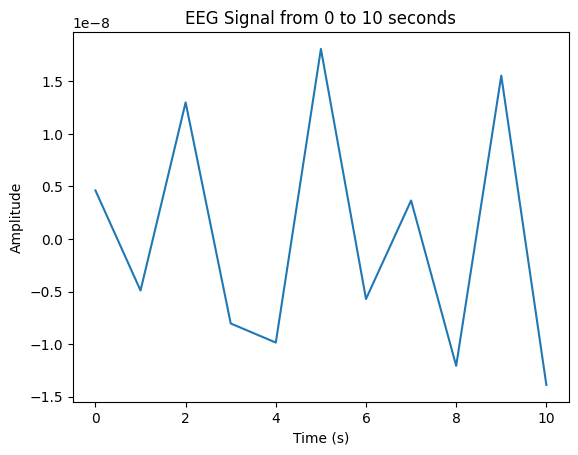

In [13]:
plot_data(processed_data['Alpha'], start=0, end=10, sampling_rate=target_fs)